In [194]:
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import torch.nn.functional as F
from tqdm import tqdm
import random
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from datetime import datetime
from torchvision import models
#from transformers import CLIPProcessor, CLIPModel
import os
import csv
from peft import LoraConfig, get_peft_model
import json

import pandas as pd
import os
import random
import numpy as np
import torch
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import json

import transformers
from transformers import CLIPProcessor, CLIPModel
from multilingual_clip import pt_multilingual_clip # Note: add device parameter to forward manually
import open_clip


from torch.utils.data import DataLoader, Dataset
from sklearn.metrics.pairwise import cosine_similarity
from transformers import pipeline

In [195]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [196]:
# loading variables from .env file
load_dotenv("../../private_data/.env") 

# PARENT gets us to the root of the project
PARENT = "./../../"

FOLDER_TABLE = PARENT + os.getenv("FOLDER_TABLE")
FILE_FABRITIUS_DATA = PARENT + os.getenv("FILE_FABRITIUS_DATA")
FILE_FABRITIUS_DATA_FILTERED = PARENT + os.getenv("FILE_FABRITIUS_DATA_FILTERED")
FILE_FABRITIUS_DATA_FILTERED_DOWNLOADED = PARENT + os.getenv("FILE_FABRITIUS_DATA_FILTERED_DOWNLOADED")
FOLDER_FIGURES = PARENT + os.getenv("FOLDER_FIGURES")
IMAGES_FOLDER = PARENT + os.getenv("IMAGES_FOLDER")
RECORD_IDS_TESTING_SET = PARENT + os.getenv("RECORD_IDS_TESTING_SET")
RECORD_IDS_VALIDATION_SET = PARENT + os.getenv("RECORD_IDS_VALIDATION_SET")
WRITTEN_CAPTIONS_TESTING_SET = PARENT + os.getenv("WRITTEN_CAPTIONS_TESTING_SET")
WRITTEN_CAPTIONS_VALIDATION_SET = PARENT + os.getenv("WRITTEN_CAPTIONS_VALIDATION_SET")
FILE_FABRITIUS_ICONOGRAPHIES_JSON = PARENT + os.getenv("FILE_FABRITIUS_ICONOGRAPHIES_JSON")
EMBEDDINGS_FOLDER = PARENT + os.getenv("EMBEDDINGS_FOLDER")
MODELS_FOLDER = PARENT + os.getenv("MODELS_FOLDER")
FILE_FABRITIUS_OTHER_DATA = PARENT + os.getenv("FILE_FABRITIUS_OTHER_DATA")
FILE_FABRITIUS_OTHER_DATA_DOWNLOADED = PARENT + os.getenv("FILE_FABRITIUS_OTHER_DATA_DOWNLOADED")
##

def fixPath(path):
    return path.replace(".././", "../")

def get_image_path_from_recordID(dataset, recordID):
    """
    Given a recordID, return the local path for its image.
    """
    # Locate row in the downloaded DataFrame
    paths = dataset[
        dataset["recordID"] == recordID
    ]["low_res_filename"].values
    
    if len(paths) == 0:
        return None
    
    path = paths[0]
    # Merge: IMAGES_FOLDER + path[1:]
    merged_path = fixPath(os.path.join(IMAGES_FOLDER, path[1:]))
    return merged_path

In [197]:
safeFormat = lambda x : x.replace("/", "_").replace(":", "_").replace(" ", "_")
model_name = "ViT-L/14"
embedding_name = safeFormat(model_name) + "_embeddings.npy"

path_imagesEmbeddings = os.path.join(EMBEDDINGS_FOLDER, "images_" + embedding_name)
path_objectsEmbeddings = os.path.join(EMBEDDINGS_FOLDER, "objects_" + embedding_name)
path_othersEmbeddings = os.path.join(EMBEDDINGS_FOLDER, "others_" + embedding_name)

imagesEmbeddings = np.load(path_imagesEmbeddings)

In [198]:
model_name = "openai/clip-vit-large-patch14"
processor = CLIPProcessor.from_pretrained(model_name)
model = CLIPModel.from_pretrained(model_name).to(device)
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
# Load the weights of the model
weights_path = os.path.join(MODELS_FOLDER, "2025-02-05 17_09_07_allFocus_5.pt")
# Load the weights of the model
model.load_state_dict(torch.load(weights_path, map_location=device))

C:\Users\victo\AppData\Local\Temp\ipykernel_22504\1192487586.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weights_path, map_location=

<All keys matched successfully>

In [199]:
DATA_WITH_ICO = pd.read_csv(FILE_FABRITIUS_DATA_FILTERED_DOWNLOADED)
# Remove rows with corrupted images
DATA_WITH_ICO = DATA_WITH_ICO[DATA_WITH_ICO["recordID"] != 11546]
DATA_WITH_ICO = DATA_WITH_ICO[DATA_WITH_ICO["recordID"] != 5262]
DATA_WITH_ICO

,recordLanguage,recordID,DatabaseId,LinkToVubis,objectWork.creatorDescription,objectWork.termClassification,objectWork.workID,objectWork.titleText,objectWork.objectWorkType,objectWork.measurementsDescription,...,objectWorkType_is_esquisse,objectWorkType_is_estampe,objectWorkType_is_grisaille,objectWorkType_is_photographie,objectWorkType_is_polyptyque,objectWorkType_is_retable,objectWorkType_is_sanguine,objectWorkType_is_triptyque,objectWorkType_is_ébauche,contains_desired_objectWorkType
0,fre,10002,Fabritius,http://193.190.214.119/fabritiusweb/LinkToVubi...,Henry de Groux,peinture (Dept. Art Moderne),12315,Portrait de Paul Verlaine,['tableau (toile)'],"[46.0, 38.0]",...,False,False,False,False,False,False,False,False,False,True
1,fre,10004,Fabritius,http://193.190.214.119/fabritiusweb/LinkToVubi...,Pierre Oyens,peinture (Dept. Art Moderne),3230,Les collègues,['tableau (toile)'],"[202.0, 177.0]",...,False,False,False,False,False,False,False,False,False,True
2,fre,10005,Fabritius,http://193.190.214.119/fabritiusweb/LinkToVubi...,Ferdinand Roybet,peinture (Dept. Art Moderne),6831,Portrait de femme,['tableau (panneau)'],"[81.0, 54.0]",...,False,False,False,False,False,False,False,False,False,True
3,fre,10016,Fabritius,http://193.190.214.119/fabritiusweb/LinkToVubi...,Henry de Groux,peinture (Dept. Art Moderne),12502,Christ aux outrages,['tableau (toile)'],"[173.0, 145.0]",...,False,False,False,False,False,False,False,False,False,True
4,fre,1003,Fabritius,http://193.190.214.119/fabritiusweb/LinkToVubi...,Alfred Stevens,peinture (Dept. Art Moderne),10714,Dame au chien,['tableau (panneau)'],"[26.9, 20.9]",...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3007,fre,9959,Fabritius,http://193.190.214.119/fabritiusweb/LinkToVubi...,"Eugène Laermans, baron",oeuvre sur papier (Dept. Art Moderne),12312,"Femme, vue de dos",['dessin'],NaN,...,False,False,False,False,False,False,False,False,False,True
3008,fre,9960,Fabritius,http://193.190.214.119/fabritiusweb/LinkToVubi...,"Eugène Laermans, baron",oeuvre sur papier (Dept. Art Moderne),12311,Sur le champ,['dessin'],NaN,...,False,False,False,False,False,False,False,False,False,True
3009,fre,9962,Fabritius,http://193.190.214.119/fabritiusweb/LinkToVubi...,Fernand Khnopff,oeuvre sur papier (Dept. Art Moderne),12264,Une aile bleue,['photographie'],NaN,...,False,False,False,True,False,False,False,False,False,True
3010,fre,999,Fabritius,http://193.190.214.119/fabritiusweb/LinkToVubi...,Constant Montald,peinture (Dept. Art Moderne),10613,La baignade,['détrempe'],"[525.0, 593.0]",...,False,False,False,False,False,False,False,False,False,True


In [200]:
DATA_WITHOUT_ICO = pd.read_csv(FILE_FABRITIUS_OTHER_DATA)
DATA_WITHOUT_ICO_DOWNLOADED = pd.read_csv(FILE_FABRITIUS_OTHER_DATA_DOWNLOADED)
# Remove the rows that are not in the downloaded data
DATA_WITHOUT_ICO = DATA_WITHOUT_ICO[DATA_WITHOUT_ICO["recordID"].isin(DATA_WITHOUT_ICO_DOWNLOADED["recordID"])]
# Remove corrupted images
corrupted = [11381]
DATA_WITHOUT_ICO = DATA_WITHOUT_ICO[~DATA_WITHOUT_ICO["recordID"].isin(corrupted)]
DATA_WITHOUT_ICO

,recordLanguage,recordID,DatabaseId,LinkToVubis,objectWork.creatorDescription,objectWork.termClassification,objectWork.workID,objectWork.titleText,objectWork.objectWorkType,objectWork.measurementsDescription,...,commissioner.commissionerName,commissioner.commissionerRole,componentsParts.componentsQuantity,componentsParts.componentsType,formalDescription.factureDescription,subjectMatter.subjectInterpretiveHistory,creator.linkAttributionDocumentation,relatedTextualReferences.citationType,materials.materialSourcePlace,creation
0,fre,1000,Fabritius,http://193.190.214.119/fabritiusweb/LinkToVubi...,Luc Peire,peinture (Dept. Art Moderne),10678,Graphie 1021,['tableau (panneau)'],"[122.0, 244.0]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'earliestDate': '1965', 'latestDate': '1966'}"
1,fre,1001,Fabritius,http://193.190.214.119/fabritiusweb/LinkToVubi...,Luc Peire,peinture (Dept. Art Moderne),10679,Graphie 1033,['tableau (panneau)'],"[122.0, 244.0]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'earliestDate': '1968', 'latestDate': '1968'}"
2,fre,10051,Fabritius,http://193.190.214.119/fabritiusweb/LinkToVubi...,Paul du Bois,sculpture (Dept. Art Moderne),12250,Femme au miroir,['plaquette'],"[37.5, 23.8, 1.3]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'earliestDate': '1977', 'latestDate': '1938'}"
3,fre,1008,Fabritius,http://193.190.214.119/fabritiusweb/LinkToVubi...,Camille van Camp,peinture (Dept. Art Moderne),7061,Paysage à Barbizon,['étude'],"[27.5, 36.0]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'earliestDate': '1854', 'latestDate': '1864'}"
4,fre,10117,Fabritius,http://193.190.214.119/fabritiusweb/LinkToVubi...,Constantin Meunier,sculpture (Dept. Art Moderne),10000 / 138,Henry Van de Velde,['haut-relief'],"[43.6, 32.15, 20.4]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'earliestDate': '1899', 'latestDate': '1899'}"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393,fre,11672,Fabritius,http://193.190.214.119/fabritiusweb/LinkToVubi...,Constantin Meunier,oeuvre sur papier (Dept. Art Moderne),10000 / 350,Cheval attaché au ratelier,['dessin'],NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'earliestDate': '1831', 'latestDate': '1905'}"
3124,fre,5370,Fabritius,http://193.190.214.119/fabritiusweb/LinkToVubi...,Paolo Farinati,oeuvre sur papier (Dept. Art Ancien),4060 / 1307 A-B,Janus (dans un médaillon) - (Verso) Deux nymph...,['dessin'],NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'earliestDate': '1570', 'latestDate': '1574'}"
3553,fre,6930,Fabritius,http://193.190.214.119/fabritiusweb/LinkToVubi...,Joseph Benoît Suvée,oeuvre sur papier (Dept. Art Ancien),4530 A-B,Homme nu assis - (Verso) Ebauche d'un homme nu...,['sanguine'],NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'earliestDate': '1761', 'latestDate': '1807'}"
3554,fre,6933,Fabritius,http://193.190.214.119/fabritiusweb/LinkToVubi...,Jan-Frans Legillon,oeuvre sur papier (Dept. Art Ancien),4642c A-B,Etude de rochers avec plantes - (Verso) Etude ...,['dessin'],NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'earliestDate': '1786', 'latestDate': '1786'}"


In [201]:
# Get the iconographies of the data with iconographies
with open(FILE_FABRITIUS_ICONOGRAPHIES_JSON, "r", encoding="utf-8") as file:
    ICONOGRAPHIES = json.load(file)

# Flatten the iconographies
def flattenIconography(iconography):
    flattened = set()

    def flatten(node):
        if not node:
            return
        value = node['value']
        children = node.get('children', [])
        if value not in ['root', '<group>']:
            flattened.add(value)

        for child in children:
            flatten(child)

    flatten(iconography)

    return list(flattened)

for recordID in tqdm(ICONOGRAPHIES.keys()):
    ICONOGRAPHIES[recordID] = flattenIconography(ICONOGRAPHIES[recordID])

ICONOGRAPHIES

100%|██████████| 3010/3010 [00:00<00:00, 182440.10it/s]


{'10002': ['figure', 'homme', 'barbe'],
 '10004': ['livre',
  'chapeau',
  'chevalet',
  'homme',
  'assis',
  'groupe de figures',
  'intérieur',
  'atelier',
  'tableau',
  'toile',
  'table',
  'fleur',
  'femme',
  'pinceau'],
 '10005': ['figure', 'en buste', 'femme', 'de profil'],
 '10016': ['animal',
  'épine',
  'arme',
  'foule',
  'lance',
  'chien',
  'casque',
  'homme',
  'cheval',
  'groupe de figures',
  'coiffure',
  'soldat',
  'femme',
  'nu',
  'couronne'],
 '1003': ['animal',
  'chapeau',
  'chien',
  'robe',
  'vêtement',
  'figure',
  'en pied',
  'femme',
  'de profil',
  'noeud'],
 '10094': ['parure',
  'à mi-corps',
  'vêtement',
  'figure',
  'harnachement',
  'femme',
  'couvre-chef'],
 '1010': ['veste', 'homme', 'figure', 'habit', 'pinceau', 'livre'],
 '10116': ['gonfanon',
  'église',
  'chandelle',
  'fillette',
  'jeune fille',
  'groupe de figures',
  'vêtement',
  'intérieur',
  'enfant',
  'chapelet',
  'coiffe'],
 '10136': ['figure', 'en buste', 'femme

In [202]:
class ComputeEmbeddingsDataset(Dataset):
    def __init__(self, dataframe, getImageFromRecordID):
        self.dataframe = dataframe
        self.getImageFromRecordID = getImageFromRecordID

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        row = self.dataframe.iloc[idx]

        recordID = row['recordID']
        caption = ""
        path = self.getImageFromRecordID(self.dataframe, recordID)

        path = path.replace("internet", "Internet")
        path = path.replace("Mod", "mod")
        path = path.replace("Old", "old")
        path = path.replace("Stefaan", "stefaan")
        path = path.replace("Art-Foto", "art-foto")
        image = Image.open(path)#.convert("RGB")

        return image, caption, recordID
    
def customBatchBuilder(samples):
    images, captions, recordIDs = zip(*samples)
    inputs = processor(text=captions, images=images, return_tensors="pt", padding=True, truncation=True)
    return inputs

In [203]:
dataset = ComputeEmbeddingsDataset(DATA_WITHOUT_ICO, get_image_path_from_recordID)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0, collate_fn=customBatchBuilder)
print(len(dataset), len(dataloader))

230 230


In [204]:
def compute_embeddings(dataloader, model, device):
    model.eval()
    embeddings = []
    with torch.no_grad():
        for sample in tqdm(dataloader):
            input_ids = sample['input_ids'].to(device)
            attention_mask = sample['attention_mask'].to(device)
            pixel_values = sample['pixel_values'].to(device)

            # Compute image embeddings
            image_features = model.get_image_features(pixel_values=pixel_values)
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
            image_features = image_features.flatten(1)

            embeddings.append(image_features)

    embeddings = torch.cat(embeddings, dim=0)
    embeddings = embeddings.cpu().numpy()
    return embeddings

newImagesEmbeddings = compute_embeddings(dataloader, model, device)
newImagesEmbeddings.shape

100%|██████████| 230/230 [00:07<00:00, 29.88it/s]


(230, 768)

In [205]:
indexToRecordID_DATA_WITH_ICO = {}
for idx, recordID in enumerate(DATA_WITH_ICO["recordID"]):
    indexToRecordID_DATA_WITH_ICO[idx] = recordID

indexToRecordID_DATA_WITHOUT_ICO = {}
for idx, recordID in enumerate(DATA_WITHOUT_ICO["recordID"]):
    indexToRecordID_DATA_WITHOUT_ICO[idx] = recordID

In [206]:
def getRecordIDWithIco(index):
    return int(DATA_WITH_ICO.iloc[index]["recordID"])

def getRecordIDWithoutIco(index):
    return int(DATA_WITHOUT_ICO.iloc[index]["recordID"])

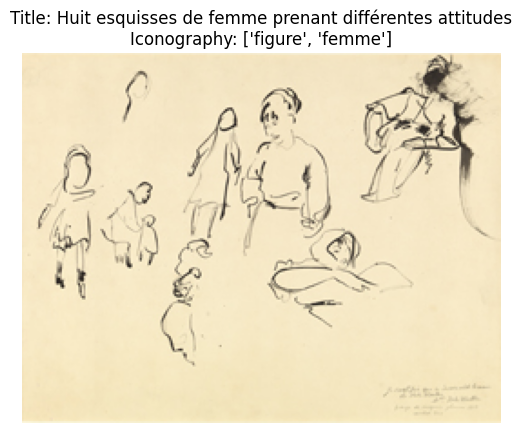

In [207]:
def display_row(rowIndex):
    # Display an image, its title and its flattened iconography
    row = DATA_WITH_ICO.iloc[rowIndex]
    recordID = getRecordIDWithIco(rowIndex)
    title = row["objectWork.titleText"]
    iconography = ICONOGRAPHIES[str(recordID)]

    text = f"Title: {title}\nIconography: {iconography}"
    path = get_image_path_from_recordID(DATA_WITH_ICO, recordID)
    image = Image.open(path)
    plt.imshow(image, cmap="gray")
    plt.title(text)
    plt.axis("off")
    plt.show()

display_row(100)

In [208]:
def get_query_embedding(query):
    model.eval()

    inputs = processor(text=query, return_tensors="pt", padding=True, truncation=True)
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    # Compute text embeddings
    text_features = model.get_text_features(input_ids=input_ids, attention_mask=attention_mask)
    #text_features = text_features / text_features.norm(dim=-1, keepdim=True)
    text_features = text_features.flatten(1)

    text_features = text_features.detach().cpu().numpy()

    text_features /= np.linalg.norm(text_features)

    return text_features

def query_using_text(text, k, imgEm, indexToRecordID):
    text_features = get_query_embedding(text)

    # Cosine similarity
    sims = cosine_similarity(text_features, imgEm)[0]
    indexes = np.argsort(sims)[::-1]

    recordIDs = [indexToRecordID(idx) for idx in indexes[:k]]
    return recordIDs

def plot_images(df, recordIDs):
    fig, axs = plt.subplots(1, len(recordIDs), figsize=(20, 5))
    for i, recordID in enumerate(recordIDs):
        axs[i].imshow(Image.open(get_image_path_from_recordID(df, recordID)), cmap="gray")
        axs[i].axis("off")
        axs[i].set_title(f"RecordID: {recordID}")
    plt.show()

In [209]:
def test():
    recordIDs = query_using_text("Portrait d'un homme", 5, imagesEmbeddings, getRecordIDWithIco)
    print(recordIDs, [3919, 7975, 6630, 3887, 4825])
    assert recordIDs == [3919, 7975, 6630, 3887, 4825], recordIDs

test()

[3919, 7975, 6630, 3887, 4825] [3919, 7975, 6630, 3887, 4825]


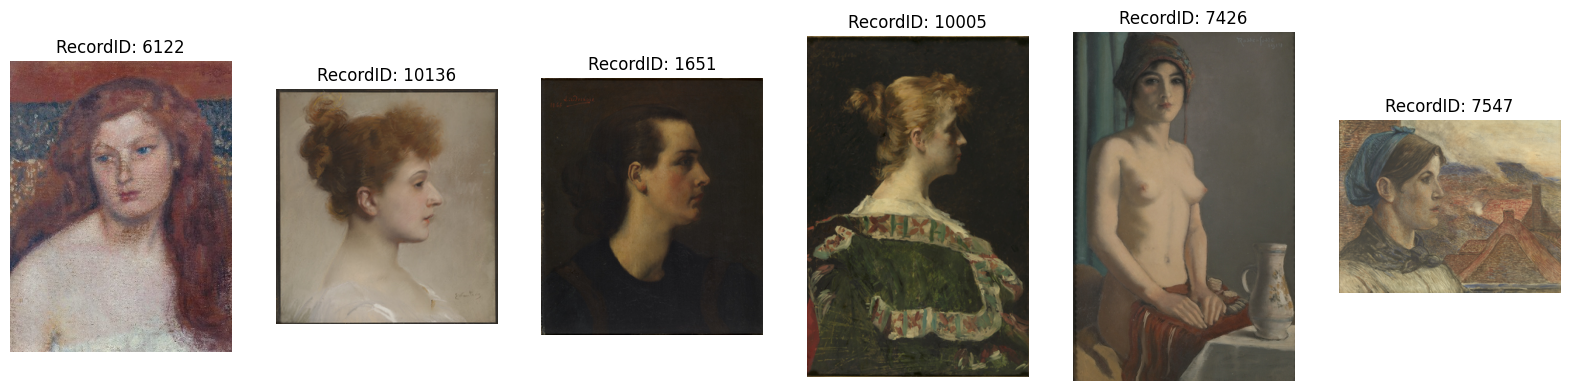

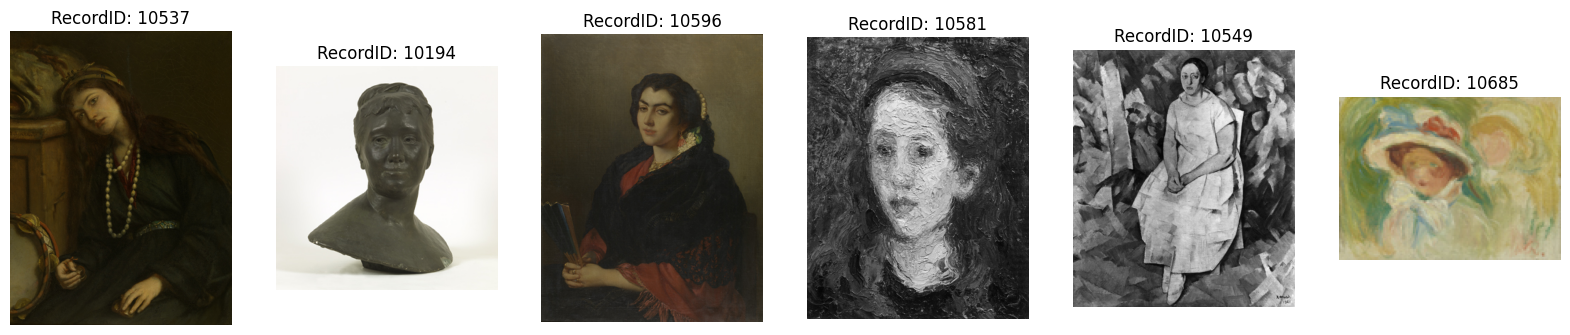

In [ ]:
k = 6
q = "Une femme"
recordIDs_old = query_using_text(q, k, imagesEmbeddings, getRecordIDWithIco)
recordIDs_new = query_using_text(q, k, newImagesEmbeddings, getRecordIDWithoutIco)
plot_images(DATA_WITH_ICO, recordIDs_old)
plot_images(DATA_WITHOUT_ICO, recordIDs_new)

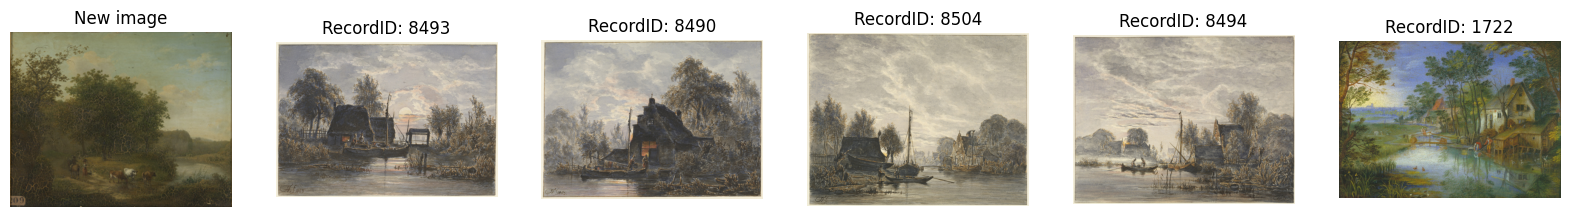

In [288]:
def get_k_closest_neighbours(index, k, neighboursEmbeddings, indexToRecordID):
    new_image_embedding = neighboursEmbeddings[index].reshape(1, -1)
    cosine_sim = cosine_similarity(new_image_embedding, neighboursEmbeddings)
    closest = np.argsort(cosine_sim[0])[-(k + 1):][::-1][1:]
    recordIDs = [indexToRecordID(idx) for idx in closest]
    return recordIDs

def plot_new_image_and_5_closest_neighbours(index):
    recordID = DATA_WITHOUT_ICO.iloc[index]["recordID"]
    fig, axs = plt.subplots(1, 6, figsize=(20, 5))
    axs[0].imshow(Image.open(get_image_path_from_recordID(DATA_WITHOUT_ICO, recordID)))
    axs[0].axis("off")
    axs[0].set_title("New image")

    recordIDs = get_k_closest_neighbours(index, 5, imagesEmbeddings, getRecordIDWithIco)

    for i, recordID in enumerate(recordIDs):
        axs[i+1].imshow(Image.open(get_image_path_from_recordID(DATA_WITH_ICO, recordID)), cmap="gray")
        axs[i+1].axis("off")
        axs[i+1].set_title(f"RecordID: {recordID}")

    plt.show()

plot_new_image_and_5_closest_neighbours(45)

In [497]:
# One-hot-encoding of the iconographies
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
mlb.fit(ICONOGRAPHIES.values())

def getIconographyOneHot(MLB, recordID):
    iconography = ICONOGRAPHIES[str(recordID)]
    return MLB.transform([iconography])[0]

def getIconographyOneHotFromIndex(MLB, index):
    recordID = DATA_WITH_ICO.iloc[index]["recordID"]
    return getIconographyOneHot(MLB, recordID)

def getIcoFromOneHotIndex(MLB, index):
    return MLB.classes_[index]

def getIconographyClassesOneHotFromIndex(MLB, index):
    recordID = DATA_WITH_ICO.iloc[index]["recordID"]
    oneHot_vector = getIconographyOneHot(MLB, recordID)
    classes = []
    for idx, value in enumerate(oneHot_vector):
        if value == 1:
            classes.append(getIcoFromOneHotIndex(MLB, idx))
    return classes 

def getKMostPopularClasses(MLB, k):
    classes = MLB.classes_
    counts = np.sum(MLB.transform(ICONOGRAPHIES.values()), axis=0)
    indexes = np.argsort(counts)[::-1][:k]
    return [classes[idx] for idx in indexes]

def getClassesWithMinimumNumberOfImages(MLB, minimum=100):
    classes = MLB.classes_
    counts = np.sum(MLB.transform(ICONOGRAPHIES.values()), axis=0)
    indexes = np.where(counts >= minimum)[0]
    return [classes[idx] for idx in indexes]

keptClasses = getClassesWithMinimumNumberOfImages(mlb, 2)
filtered_iconographies = {recordID: [ico for ico in ICONOGRAPHIES[recordID] if ico in keptClasses] for recordID in ICONOGRAPHIES.keys()}

In [498]:
mlb_filtered = MultiLabelBinarizer()
mlb_filtered.fit(filtered_iconographies.values())

getIconographyClassesOneHotFromIndex(mlb_filtered, 60)

['barbe',
 'couvre-chef',
 'de profil',
 'en buste',
 'figure',
 'homme',
 'local',
 'moustache']

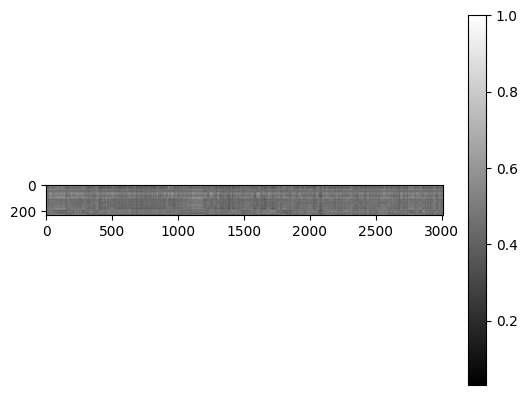

In [499]:
C = cosine_similarity(newImagesEmbeddings, imagesEmbeddings)
# Display C
plt.imshow(C, cmap="gray")
plt.colorbar()
plt.show()

In [493]:
def measure_average_ico_response(term):
    # Embed the term, get the average cosine similarity with the images that do not contain the term in their iconography
    term_embedding = get_query_embedding(term)
    term_embedding = term_embedding.reshape(1, -1)
    
    images_index_with = [idx for idx, recordID in enumerate(DATA_WITH_ICO["recordID"]) if term in ICONOGRAPHIES[str(recordID)]]
    images_index_without = [idx for idx, recordID in enumerate(DATA_WITH_ICO["recordID"]) if term not in ICONOGRAPHIES[str(recordID)]]

    images_embeddings_with = imagesEmbeddings[images_index_with]
    images_embeddings_without = imagesEmbeddings[images_index_without]

    C_with = cosine_similarity(term_embedding, images_embeddings_with)
    C_without = cosine_similarity(term_embedding, images_embeddings_without)

    return np.mean(C_without), np.mean(C_with)

measure_average_ico_response("homme")

(np.float32(0.16097045), np.float32(0.18148707))

In [436]:
corrector_per_term = {}
for term in tqdm(mlb_filtered.classes_):
    corrector_per_term[term] = [float(x) for x in measure_average_ico_response(term)]

corrector_per_term

100%|██████████| 53/53 [00:01<00:00, 32.04it/s]


{'aile': [0.1479261815547943, 0.15145212411880493],
 'animal': [0.15152063965797424, 0.1711295247077942],
 'arbre': [0.11846765875816345, 0.16019386053085327],
 'architecture': [0.15195654332637787, 0.1845027655363083],
 'arme': [0.14941315352916718, 0.149152010679245],
 'assis': [0.15533070266246796, 0.1839972585439682],
 'barbe': [0.1487804800271988, 0.1792929321527481],
 'bateau': [0.15248724818229675, 0.2198363095521927],
 'bijou': [0.17674826085567474, 0.18234127759933472],
 'bâtiment': [0.15743215382099152, 0.18743407726287842],
 'bâton': [0.18742744624614716, 0.1892201155424118],
 'cavalier': [0.18141105771064758, 0.2171575427055359],
 'chaise': [0.13993893563747406, 0.16584116220474243],
 'chapeau': [0.12737953662872314, 0.14812009036540985],
 'cheval': [0.16379007697105408, 0.21513286232948303],
 'chien': [0.14128540456295013, 0.16638943552970886],
 'ciel': [0.16805042326450348, 0.18119461834430695],
 'clocher': [0.15021724998950958, 0.18619637191295624],
 'coiffe': [0.1499654

[0.         0.         0.         0.         0.         0.
 0.         0.         0.46157628 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.8918722  0.         0.         0.         0.         0.
 0.         0.         0.87157771 0.         0.         0.
 0.         0.         0.43425822 0.         0.         0.56153977
 0.         0.49488932 0.         0.43731949 0.         0.45455271
 0.         0.         0.         0.         0.89889577 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.96660876
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.45455271
 0.         0.         0

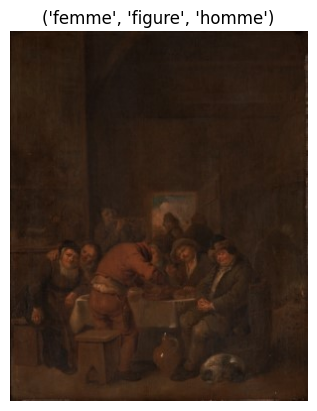

In [526]:
def estimate_iconography_using_neighbours_iconographies(index, C, iconographies, k, threshold=0.4):
    recordID = getRecordIDWithoutIco(index)
    neighboursRecordIDs = get_k_closest_neighbours(index, k, C, getRecordIDWithIco)
    neighbours_oneHot_iconographies = [getIconographyOneHot(mlb_filtered, recordID) for recordID in neighboursRecordIDs]

    # Multiply the one-hot iconographies of the neighbours by the cosine similarity
    weighted_iconographies = np.zeros(neighbours_oneHot_iconographies[0].shape)
    Cs = [C[index][i] for i in range(k)]
    for i, neighbour in enumerate(neighbours_oneHot_iconographies):
        weighted_iconographies += neighbour * C[index][i]

    print(weighted_iconographies)

    weighted_iconographies /= np.sum(Cs)


    weighted_iconographies[weighted_iconographies > threshold] = 1
    weighted_iconographies[weighted_iconographies <= threshold] = 0

    if False:
        # Correct the weighted_iconographies
        for i, value in enumerate(weighted_iconographies):
            term = getIcoFromOneHotIndex(mlb_filtered, i)
            corrector = corrector_per_term.get(term)
            weighted_iconographies[i] -= corrector[0]
            weighted_iconographies[i] /= corrector[1]
            weighted_iconographies = np.clip(weighted_iconographies, 0, 1)

    estimated_iconography = mlb_filtered.inverse_transform(np.array([weighted_iconographies]))[0]
    return estimated_iconography
    
def plot_image_and_estimated_ico(index, k=10):
    estimated_ico = estimate_iconography_using_neighbours_iconographies(index, C, filtered_iconographies, k)
    recordID = getRecordIDWithoutIco(index)
    image = Image.open(get_image_path_from_recordID(DATA_WITHOUT_ICO, recordID))
    plt.imshow(image, cmap="gray")
    plt.title(f"{estimated_ico}")
    plt.axis("off")
    plt.show()

plot_image_and_estimated_ico(random.randint(0, len(DATA_WITHOUT_ICO)), k=10)